# Leaf Cost and Net Uptake analysis

## Setup

Load up the necessary packages

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf
from scipy.signal import find_peaks
plt.rcParams["figure.figsize"]=15,10

Load in the data

In [44]:
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-ckovenparam-cnlf.C137514abc-F92150a45.2020-02-12/run/lnd/hist/concat.nc' # 30 year run
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-ckovenparam-twoll.C137514abc-F99503c9a.2020-02-12/run/lnd/hist/concat.nc' # Only using last two leaf levels
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-leafcost.C137514abc-Fabb2d56e.2020-02-13/run/lnd/hist/concat.nc' # Adding leaf cost to the history output
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-optlai.C137514abc-F5f725c39.2020-02-13/run/lnd/hist/concat.nc' # sla_levleaf calculated from optimium cumulative lai
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-longrun-stndvars.C137514abc-Ffbbcafd0.2020-02-24/run/lnd/hist/concat.nc' # 150 year master branch run
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-tallestoutputonly.C137514abc-F3c05d18c.2020-02-25/run/lnd/hist/concat.nc' #
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-tallestoutputonly-notrimadd.C137514abc-F3c05d18c.2020-02-25/run/lnd/hist/concat.nc' # removed trim inc add for tallest cohort
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-llsf.C137514abc-Fc26723e7.2020-03-03/run/lnd/hist/concat.nc' # 15 year standard run with output to log
# file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-llsf.C137514abc-Ff596cd86.2020-03-06/run/lnd/hist/concat.nc' # 15 year standard run with output to log and yarly output
file = '/home/glemieux/scratch/clmed-cases/leaf_flutter-bci-llsf.C137514abc-Ff596cd86.2020-03-11/run/lnd/hist/concat.nc' # Includes cumulative lai output
# file = 'concat.nc' # local file

In [96]:
ncfile = netcdf.netcdf_file(file,'r',mmap=False)

### Setup the variables of interest

Copy variables to main memory

In [97]:
# Time
timevar = ncfile.variables['time']
time = timevar[:].copy()
np.shape(time)

(180,)

In [98]:
# TLAI
tlaivar = ncfile.variables['TLAI'] # Total projected leaf area index (for whole patch?)
tlai = tlaivar[:].copy()
np.shape(tlai)

(180, 1)

In [99]:
tlai = np.reshape(tlai,180)

In [100]:
# LAI sun, shade and in canopy by size class
laisun = ncfile.variables['LAISUN_Z_CNLF'][:].copy()
laisha = ncfile.variables['LAISHA_Z_CNLF'][:].copy()
lai_can_scls = ncfile.variables['LAI_CANOPY_SCLS'][:].copy()
np.shape(lai_can_scls)

(180, 36, 1)

In [101]:
laisun = np.reshape(laisun,(180,60))
laisha = np.reshape(laisha,(180,60))
lai_can_scls = np.reshape(lai_can_scls,(180,36))

In [102]:
# Crown area
crownarea_cnlf = ncfile.variables['CROWNAREA_CNLF'][:].copy()
np.shape(crownarea_cnlf)

(180, 60, 1)

In [103]:
crownarea_cnlf = np.reshape(crownarea_cnlf,(180,60))

In [104]:
# Trimming
trim = ncfile.variables['TRIMMING'][:].copy()
trim_can = ncfile.variables['TRIMMING_CANOPY_SCLS'][:].copy()
trim_und = ncfile.variables['TRIMMING_UNDERSTORY_SCLS'][:].copy()
np.shape(trim)
np.shape(trim_can)

(180, 36, 1)

In [105]:
trim = np.reshape(trim,180)
trim_can = np.reshape(trim_can,(180,36))
trim_und = np.reshape(trim_und,(180,36))

In [106]:
# Number of plants
nplants_scls = ncfile.variables['NPLANT_SCLS'][:].copy()
nplants_scls_can = ncfile.variables['NPLANT_CANOPY_SCLS'][:].copy()
nplants_scls_und = ncfile.variables['NPLANT_UNDERSTORY_SCLS'][:].copy()
np.shape(nplants_scls_can)

(180, 36, 1)

In [107]:
nplants_scls = np.reshape(nplants_scls,(180,36))
nplants_scls_can = np.reshape(nplants_scls_can,(180,36))
nplants_scls_und = np.reshape(nplants_scls_und,(180,36))

In [108]:
# Net uptake, timestep
net_uptake_ts = ncfile.variables['NET_C_UPTAKE_CNLF'][:].copy()
# Net uptake, yearly
net_uptake_yrly = ncfile.variables['YRLY_UPTAKE_CNLF'][:].copy()
np.shape(net_uptake_yrly)

(180, 60, 1)

In [109]:
net_uptake_ts = np.reshape(net_uptake_ts,(180,60))
net_uptake_yrly = np.reshape(net_uptake_yrly,(180,60))

In [110]:
# Leaf cost, yearly
leafcost = ncfile.variables['LEAF_COST_CNLF'][:].copy()
np.shape(leafcost)

(180, 60, 1)

In [111]:
leafcost = np.reshape(leafcost,(180,60))

In [112]:
# Cumulative LAI, yearly
cumulative_lai = ncfile.variables['CUMULATIVE_LAI_CNLF'][:].copy()
np.shape(cumulative_lai)

(180, 60, 1)

In [113]:
cumulative_lai = np.reshape(cumulative_lai,(180,60))

Close file

In [114]:
ncfile.close()

### Set the necessary parameters

In [115]:
# Hardcoded parameters
maxcls = 2
leaflayers = 30 # per canopy layer
scls = 36

# Conversions
sec_per_min = 60.
min_per_hour = 60.
hour_per_day = 24.
day_per_year = 365.
months_per_year = 12.
sec_per_hour = sec_per_min * min_per_hour
sec_per_day = sec_per_hour * hour_per_day
sec_per_year = sec_per_day * day_per_year
print('Seconds per day:',sec_per_day)

# Time variations
simtime_days = time[:]
simtime_years = time[:]/365
simtime_months = simtime_years*12
print('simtime time step [days]:', simtime_days[178]-simtime_days[177])
print('simtime_days:',simtime_days[-1])
print('simtime_years:',simtime_years[-1])
print('simtime_months:',simtime_months[-1])
years = int(simtime_years[-1])
months = int(simtime_months[-1])
days = int(simtime_days[-1])

Seconds per day: 86400.0
simtime time step [days]: 30.0
simtime_days: 5475.0
simtime_years: 15.0
simtime_months: 180.0


### Commentary on `cnlf` indexing and history output 

### History output

The FatesHistoryInterfaceMod sums up `ts_net_uptake` for each leaf layer for *each cohort* everytime `update_history_prod` is called (which is half-hourly).  `year_net_uptake` is accumulated in the EDCohortDynamicsMod during fusion and in `AccumulateFluxes_ED` procedure from the similarly named module.  It is not reported directly to history output.  

Note that the results of this is that the `ts_net_uptake` ***can not*** be indexed by cohort directly as it is summing up over all cohorts.

### `cnlf` indexing

Indexing by `cnlf` is defined by: `cnlf_indx = ileaf + (ican-1) * nlevleaf`, where `ileaf` is the current cohort leaf layer number, `ican` is the current cohort canopy layer number and `nlevleaf` is the total possible leaf levels in a canopy (hardcoded as `nlevleaf = 30` currently).  

For example, with `ileaf = 7` and `ican = 1`, we get `cnlf_indx = 7 + (1-1) * 30 = 7`.  For the understory (`ican = 2`) with the same leaf layer we get `cnlf_indx = 7 + (2-1) * 30 = 37`.  As such we can split the variable data sets along canopy layers into two differently named canopy layer data sets (e.g. `nu_cls1` and `nu_cls2`). 

### Split variable data sets along the canopy layer dimension

There are two canopy layers

In [63]:
np.shape(np.hsplit(net_uptake_yrly,maxcls))

(2, 180, 30)

In [64]:
# Net uptake, yearly
nu_hsplit = np.hsplit(net_uptake_yrly,maxcls)
nu_cls1 = nu_hsplit[0]
nu_cls2 = nu_hsplit[1]

In [65]:
# Leaf cost, yearly
lc_hsplit = np.hsplit(leafcost,maxcls)
lc_cls1 = lc_hsplit[0]
lc_cls2 = lc_hsplit[1]
np.shape(lc_cls1)

(180, 30)

In [116]:
# Cumulative LAI
clai_hsplit = np.hsplit(cumulative_lai,maxcls)
clai_cls1 = clai_hsplit[0]
clai_cls2 = clai_hsplit[1]
np.shape(clai_cls1)

(180, 30)

In [66]:
# LAI sun and shade
lsun_hsplit = np.hsplit(laisun,maxcls)
lsha_hsplit = np.hsplit(laisha,maxcls)
# Sun
lsun_cls1 = lsun_hsplit[0]
lsun_cls2 = lsun_hsplit[1]
# Shade
lsha_cls1 = lsha_hsplit[0]
lsha_cls2 = lsha_hsplit[1]

In [67]:
# Crown area
crownarea_hsplit = np.hsplit(crownarea_cnlf,maxcls)
crownarea_cls1 = crownarea_hsplit[0]
crownarea_cls2 = crownarea_hsplit[1]
np.shape(crownarea_cls1)

(180, 30)

### Split variable data sets along the time dimension into years

Split into yearly segments

In [68]:
np.shape(np.vsplit(nu_cls1,years))

(15, 12, 30)

In [69]:
# Net uptake, yearly
nu_cls1_vsplit = np.vsplit(nu_cls1,years)
nu_cls2_vsplit = np.vsplit(nu_cls2,years)
np.shape(nu_cls1_vsplit)

(15, 12, 30)

In [70]:
# Leaf Cost, yearly
lc_cls1_vsplit = np.vsplit(lc_cls1,years)
lc_cls2_vsplit = np.vsplit(lc_cls2,years)
np.shape(lc_cls1_vsplit)

(15, 12, 30)

In [117]:
# Cumulative LAI
clai_cls1_vsplit = np.vsplit(clai_cls1,years)
clai_cls2_vsplit = np.vsplit(clai_cls2,years)
np.shape(clai_cls1_vsplit)

(15, 12, 30)

In [71]:
# LAI - Sun
lsun_cls1_vsplit = np.vsplit(lsun_cls1,years)
lsun_cls2_vsplit = np.vsplit(lsun_cls2,years)
# LAI - Shade
lsha_cls1_vsplit = np.vsplit(lsha_cls1,years)
lsha_cls2_vsplit = np.vsplit(lsha_cls2,years)
np.shape(lsha_cls1_vsplit)

(15, 12, 30)

In [72]:
# Crown Area
crownarea_cls1_vsplit = np.vsplit(crownarea_cls1,years)
crownarea_cls2_vsplit = np.vsplit(crownarea_cls2,years)
np.shape(crownarea_cls2_vsplit)

(15, 12, 30)

Sum up along the yearly splits.  *Note that net uptake (yearly) and leaf cost is already yearly*

In [73]:
# LAI - Sun
lsun_cls1_yearly = np.sum(lsun_cls1_vsplit,1)
lsun_cls2_yearly = np.sum(lsun_cls2_vsplit,1)
# LAI - Shade
lsha_cls1_yearly = np.sum(lsha_cls1_vsplit,1)
lsha_cls2_yearly = np.sum(lsha_cls2_vsplit,1)
np.shape(lsun_cls1_yearly)

(15, 30)

In [74]:
# Crown area
crownarea_cls1_yearly = np.sum(crownarea_cls1_vsplit,1)
crownarea_cls2_yearly = np.sum(crownarea_cls2_vsplit,1)
np.shape(crownarea_cls2_yearly)

(15, 30)

## Plot the yearly leaf cost and net uptake

First plot out versus time to see what things look like

In [75]:
np.shape(crownarea_cls1)

(180, 30)

Text(0, 0.5, 'Cumulative LAI')

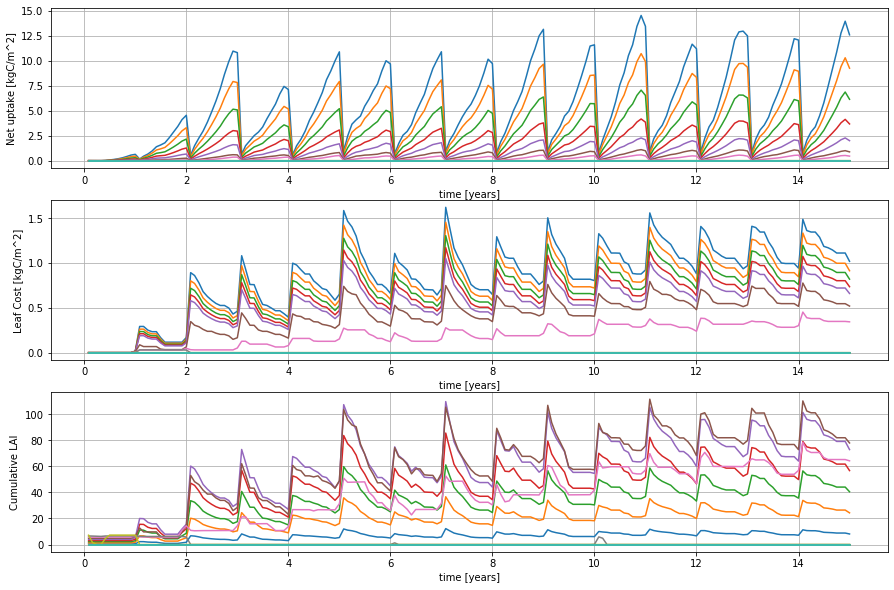

In [170]:
ll = leaflayers
# ll = 1

# Net Uptake
plt.subplot(311)
for z in range(ll): 
    plt.plot(simtime_years,nu_cls1[:,z])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("Net uptake [kgC/m^2]")
# plt.xlim([0,3])

# Leaf Cost
plt.subplot(312)
for z in range(ll): 
    plt.plot(simtime_years,lc_cls1[:,z])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("Leaf Cost [kgC/m^2]")
# plt.xlim([0,3])

# Cumulative LAI
plt.subplot(313)
for z in range(ll): 
    plt.plot(simtime_years,clai_cls1[:,z])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("Cumulative LAI")
# plt.xlim([0,3])

Determine the points in time of the maximum uptake and leaf cost (start with just the last layer for now)

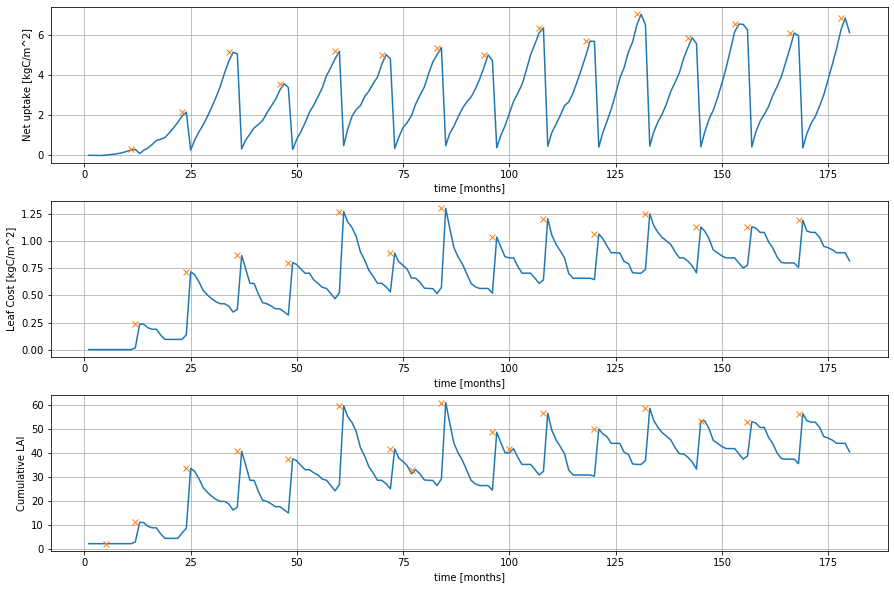

In [171]:
z = 2 # leaf layer
peaks_nu, _ = find_peaks(nu_cls1[:,z])
peaks_lc, _ = find_peaks(lc_cls1[:,z])
peaks_clai, _ = find_peaks(clai_cls1[:,z])

plt.subplot(311)
plt.plot(simtime_months,nu_cls1[:,z])
plt.plot(peaks_nu,nu_cls1[peaks_nu,z],"x")
plt.grid()
plt.xlabel("time [months]")
plt.ylabel("Net uptake [kgC/m^2]")

plt.subplot(312)
plt.plot(simtime_months,lc_cls1[:,z])
plt.plot(peaks_lc,lc_cls1[peaks_lc,z],"x")
plt.grid()
plt.xlabel("time [months]")
plt.ylabel("Leaf Cost [kgC/m^2]")

plt.subplot(313)
plt.plot(simtime_months,clai_cls1[:,z])
plt.plot(peaks_clai,clai_cls1[peaks_clai,z],"x")
plt.grid()
plt.xlabel("time [months]")
plt.ylabel("Cumulative LAI")

plt.subplots_adjust(hspace = 0.25)

Text(0, 0.5, 'Net-Net Uptake [kgC/m2]')

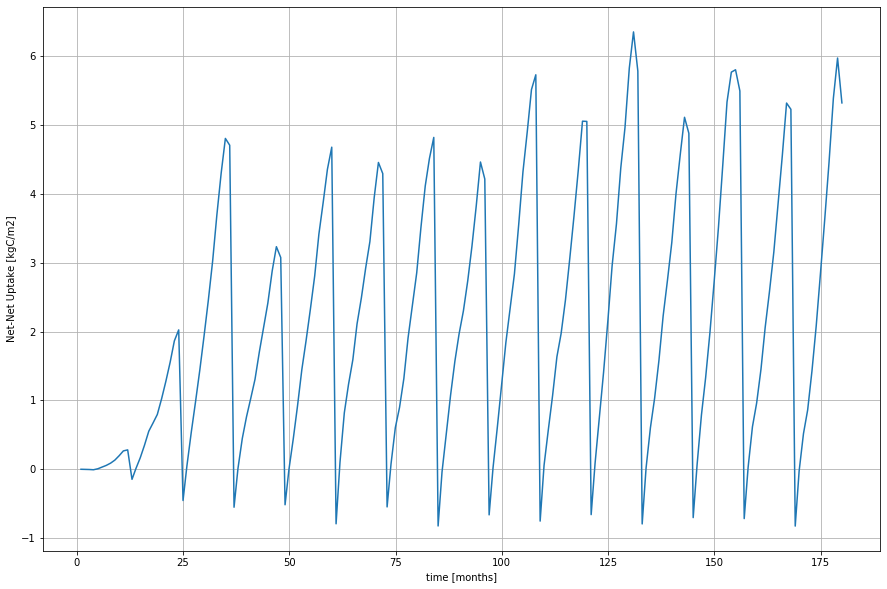

In [172]:
plt.plot(simtime_months,nu_cls1[:,z]-lc_cls1[:,z])
# plt.plot(peaks_clai,clai_cls1[peaks_clai,z],"x")
plt.grid()
plt.xlabel("time [months]")
plt.ylabel("Net-Net Uptake [kgC/m2]")

In [160]:
# Where are the peaks?
print('Peak indices:')
print('\tNet uptake peaks:', peaks_nu)
print('\tLeaf cost peaks:', peaks_lc)
print()
print('Number of Layers at peak index:')

# Insert indices as necessary
# peaks_lc = np.insert(peaks_lc,0,11)

# print('Net uptake peaks:', peaks_nu)
# print('Leaf cost peaks:', peaks_lc)

# How many leaf layers at each peak?
leaflayers_lc = np.empty(np.size(peaks_lc))
for i,p in enumerate(peaks_lc):
    leaflayers_lc[i] = np.count_nonzero(lc_cls1[p,:])
print('\tLeaf Cost:', leaflayers_lc)
    
leaflayers_nu = np.empty(np.size(peaks_nu))
for i,p in enumerate(peaks_nu):
    leaflayers_nu[i] = np.count_nonzero(nu_cls1[p,:])
print('\tNet Uptake:', leaflayers_nu)

Peak indices:
	Net uptake peaks: [ 11  23  34  46  59  70  83  94 107 118 130 142 153 166 178]
	Leaf cost peaks: [ 12  24  36  48  60  72  84  96 108 120 132 144 156 168]

Number of Layers at peak index:
	Leaf Cost: [9. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]
	Net Uptake: [9. 8. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7. 7.]


## Spot check history input against lnd.log 

Manually enter in log output for year 15 summed across all cohorts (see google drive sheet)

In [150]:
# Net Uptake, kgC/m2
nu_yr15_logout = np.array([0., 0., 0., 0.6688, 0.3492, 0.1552, 0.1252])

# Leaf Cost, kgC/m2
lc_yr15_logout = np.array([0., 0., 0., 0.4793, 0.4300, 0.3858, 0.3623])

# Cumulative LAI
clai_yr15_logout = np.array([0., 0., 0., 35.0, 45.0, 55.0, 60.8182])

Net uptake

In [151]:
# Go through history output variables
leaflayerdepth = 4
c = 1
nleaflayers = int(leaflayers_nu[-1])
testzlayers = np.arange(0,nleaflayers)
m = int(peaks_nu[-2])
print('Month:', m)
# for m in peaks_nu:
for z in testzlayers[nleaflayers:nleaflayers-(leaflayerdepth+1):-1]:
#     print('Month:', m, 'Canopy Layer:', c, 'Leaf Layer:', z+1)
    print('Leaf Layer:', z+1)
    print('History output:')
    print('\tNet Carbon Uptake (kgC/m2/year):', nu_cls1[m,z])
    print('Log output:')
    print('\tNet Carbon Uptake (kgC/m2/year):', lo_nu_cls1_yrly_correct[z])

#     print('Difference')
#     print('\tLeaf Cost Diff:', lo_lc_cls1_yrly_correct[z]-lc_cls1_yrly_correct[y-1,z])
#     print('\tNet Carbon Uptake Diff:', lo_nu_cls1_yrly_correct[z]-nu_cls1_yrly_correct[y-1,z])
    print()

Month: 167
Leaf Layer: 7
History output:
	Net Carbon Uptake (kgC/m2/year): 0.556022
Log output:
	Net Carbon Uptake (kgC/m2/year): 0.1252

Leaf Layer: 6
History output:
	Net Carbon Uptake (kgC/m2/year): 1.0191579
Log output:
	Net Carbon Uptake (kgC/m2/year): 0.1552

Leaf Layer: 5
History output:
	Net Carbon Uptake (kgC/m2/year): 2.0021155
Log output:
	Net Carbon Uptake (kgC/m2/year): 0.3492

Leaf Layer: 4
History output:
	Net Carbon Uptake (kgC/m2/year): 3.6033533
Log output:
	Net Carbon Uptake (kgC/m2/year): 0.6688



Leaf Cost

In [152]:
# Go through history output variables, Leaf Cost (Combine with above later)
leaflayerdepth = 4
c = 1
nleaflayers = int(leaflayers_lc[-1]) # leaf cost
testzlayers = np.arange(0,nleaflayers)
m = int(peaks_lc[-2])
print('Month:', m)
# for m in peaks_nu:
for z in testzlayers[nleaflayers:nleaflayers-(leaflayerdepth+1):-1]:
#     print('Month:', m, 'Canopy Layer:', c, 'Leaf Layer:', z+1)
    print('Leaf Layer:', z+1)
    print('History output:')
    print('\tLeaf Cost (kgC/m2/year):', lc_cls1[m,z])
    print('Log output:')
    print('\tLeaf Cost (kgC/m2/year):', lo_lc_cls1_yrly_correct[z])

Month: 156
Leaf Layer: 7
History output:
	Leaf Cost (kgC/m2/year): 0.35245246
Log output:
	Leaf Cost (kgC/m2/year): 0.3623
Leaf Layer: 6
History output:
	Leaf Cost (kgC/m2/year): 0.74160904
Log output:
	Leaf Cost (kgC/m2/year): 0.3858
Leaf Layer: 5
History output:
	Leaf Cost (kgC/m2/year): 0.9129685
Log output:
	Leaf Cost (kgC/m2/year): 0.43
Leaf Layer: 4
History output:
	Leaf Cost (kgC/m2/year): 1.0170482
Log output:
	Leaf Cost (kgC/m2/year): 0.4793


Cumulative LAI

In [89]:
# Go through history output variables, Cumulative LAI (Combine with above later)
leaflayerdepth = 4
c = 1
nleaflayers = int(leaflayers_lc[-1]) # leaf cost
testzlayers = np.arange(0,nleaflayers)
m = int(peaks_lc[-2])
print('Month:', m)
# for m in peaks_nu:
for z in testzlayers[nleaflayers:nleaflayers-(leaflayerdepth+1):-1]:
#     print('Month:', m, 'Canopy Layer:', c, 'Leaf Layer:', z+1)
    print('Leaf Layer:', z+1)
    print('History output:')
    print('\tLeaf Cost (kgC/m2/year):', lc_cls1[m,z])
#     print('Log output:')
#     print('\tLeaf Cost (kgC/m2/year):', lo_lc_cls1_yrly_correct[z])

Month: 156
Leaf Layer: 7
History output:
	Leaf Cost (kgC/m2/year): 0.35245246
Log output:
	Leaf Cost (kgC/m2/year): 0.3623
Leaf Layer: 6
History output:
	Leaf Cost (kgC/m2/year): 0.74160904
Log output:
	Leaf Cost (kgC/m2/year): 0.3858
Leaf Layer: 5
History output:
	Leaf Cost (kgC/m2/year): 0.9129685
Log output:
	Leaf Cost (kgC/m2/year): 0.43
Leaf Layer: 4
History output:
	Leaf Cost (kgC/m2/year): 1.0170482
Log output:
	Leaf Cost (kgC/m2/year): 0.4793


## Plot out the trimming and compare to LAI

Text(0, 0.5, 'canopy_trim')

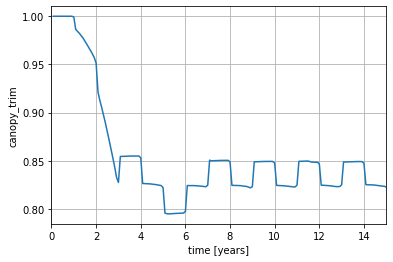

In [30]:
plt.plot(time_yearly[:],trim[:])
plt.grid()
plt.xlim([0,time_yearly[-1]])
plt.xlabel("time [years]")
plt.ylabel("canopy_trim")

`canopy_trim` definitely seems to be banging around $0.825$ here.  Testing the data sets that use different numbers of leaf levels does not change the bang-bang response character.

Plot out the trimming per sizeclass for each canopy layer level

/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'canopy_trim')

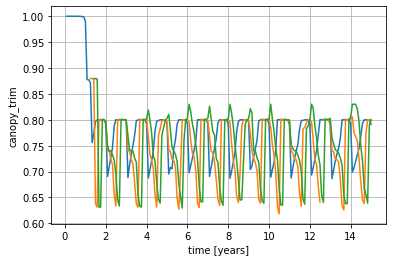

In [31]:
for s in range(0,3):
    plt.plot(time_yearly[:],trim_can[:,s]/nplants_scls_can[:,s])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("canopy_trim")

/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'canopy_trim')

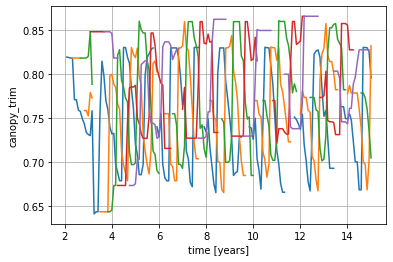

In [32]:
for s in range(5,10):
    plt.plot(time_yearly[:],trim_can[:,s]/nplants_scls_can[:,s])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("canopy_trim")

/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'canopy_trim')

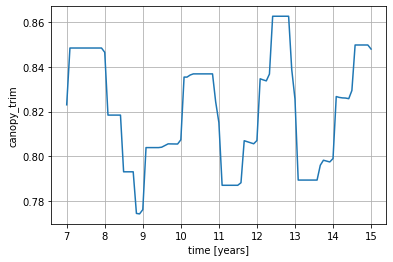

In [33]:
# Individual plot
i = 13
plt.plot(time_yearly[:],trim_can[:,i]/nplants_scls_can[:,i])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("canopy_trim")

/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/gregorylemieux/local/miniconda3/en

Text(0, 0.5, 'canopy_trim')

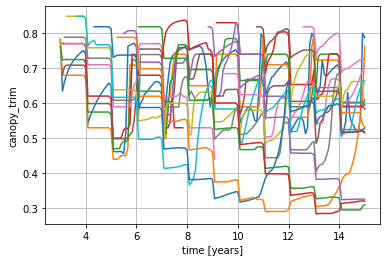

In [34]:
for s in range(0,36):
    plt.plot(time_yearly[:],trim_und[:,s]/nplants_scls_und[:,s])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("canopy_trim")

/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, 'canopy_trim')

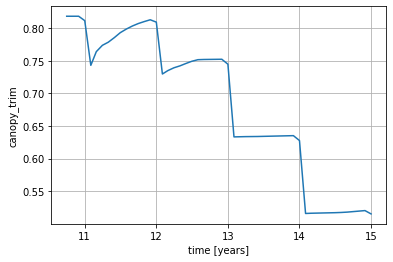

In [35]:
i = 15
plt.plot(time_yearly[:],trim_und[:,i]/nplants_scls_und[:,i])
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("canopy_trim")

Overlay the overall trimming plot and different trims by size class

/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


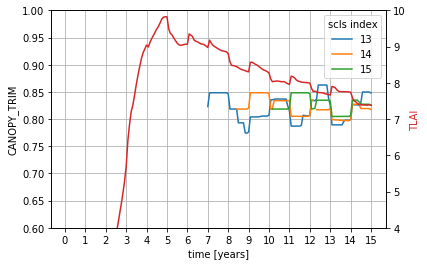

In [36]:
fig, ax1 = plt.subplots()
# ax1.plot(time[:],trim[:])
ax1color = 'tab:blue'
for s in range(13,16):
    ax1.plot(time_yearly[:],trim_can[:,s]/nplants_scls_can[:,s],label=str(s))
ax1.grid()
# ax1.set_xlim([0,time[-1]])
# ax1.set_xlim([25000,40000])
ax1.set_xlabel("time [years]")
ax1.set_ylabel("CANOPY_TRIM")
ax1.set_ylim(.60,1)
ax1.xaxis.set_ticks(np.arange(0,16,1))
ax1.legend(title='scls index')

ax2 = ax1.twinx()
ax2color = 'tab:red'
ax2.set_ylabel('TLAI',color=ax2color)
ax2.plot(time_yearly[:],tlai[:],ax2color)
ax2.set_ylim(4,10)
fig.savefig('tlai-vs-cantrim.png')

It seems that the appearance of largest size classes in the top canopy have specific time windows that correlate with the increase in LAI to that size class `TRIMMING` value.  This makes sense since the top canopy level will have the largest size classes and the overall trimming value is defined to report only the tallest:
```
hio_trimming_pa(io_pa) = cpatch%tallest%canopy_trim
```
Not however, that the trimming value of the new largest size class starts out around some overall average value before bumping up.  How does the evolution of the trees into a taller size class look?  Lets look at how a new size class is reported:

(4, 10)

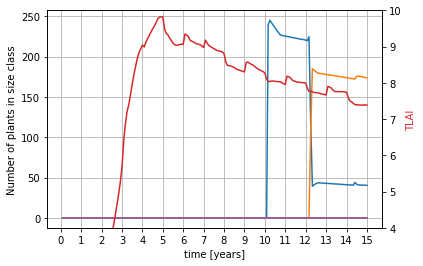

In [37]:
fig, ax1 = plt.subplots()
# ax1.plot(time[:],trim[:])
ax1color = 'tab:blue'
for s in range(15,20):
    ax1.plot(time_yearly[:],nplants_scls[:,s])
ax1.grid()
# ax1.set_xlim([0,time[-1]])
# ax1.set_xlim([0,10000])
ax1.set_xlabel("time [years]")
ax1.set_ylabel("Number of plants in size class")
# ax1.set_ylim(.75,1)
ax1.xaxis.set_ticks(np.arange(0,16,1))

ax2 = ax1.twinx()
ax2color = 'tab:red'
ax2.set_ylabel('TLAI',color=ax2color)
ax2.plot(time_yearly[:],tlai[:],ax2color)
ax2.set_ylim(4,10)

This isn't very illuminating really.  Just for comparison lets look at the total size classes:  

/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/gregorylemieux/local/miniconda3/envs/lbl/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


([<matplotlib.axis.XTick at 0x7f8c1fdcf7f0>,
 <a list of 16 Text xticklabel objects>)

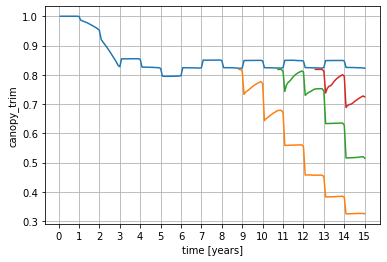

In [38]:
plt.plot(time_yearly[:],trim[:])
for s in range(14,17):
    plt.plot(time_yearly[:],trim_und[:,s]/nplants_scls_und[:,s])
#     plt.plot(time[:],trim[:]- trim_can[:,s]/nplants_scls_can[:,s]) # Difference
plt.grid()
# plt.xlim([0,time[-1]])
plt.xlabel("time [years]")
plt.ylabel("canopy_trim")
plt.xticks(np.arange(0,16,1))

The above plot is to compare the understory to the canopy size class.  We can see a correlation between the new largest understory size class appearance here as well, although it does not have the same squarewave pattern.

## Plot net uptake versus time for a given leaf layer

Canopy (cohort) level 1

Text(0, 0.5, 'gC/m^2/s')

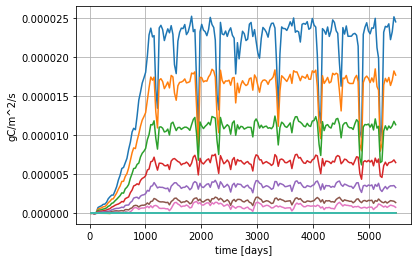

In [39]:
# Monthly (timestep)
for z in range(leaflayers): 
    plt.plot(time[:],nu_cls1[:,z])
plt.grid()
plt.xlabel("time [days]")
plt.ylabel("gC/m^2/s")

Text(0, 0.5, 'gC/m^2/s')

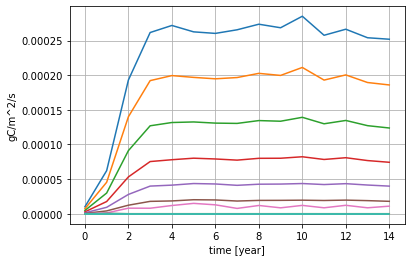

In [40]:
# Yearly 
for z in range(leaflayers): 
    plt.plot(np.arange(years),nu_cls1_yearly[:,z])
plt.grid()
plt.xlabel("time [year]")
plt.ylabel("gC/m^2/s")

Canopy level 2 (understory)

Text(0, 0.5, 'gC/m^2/s')

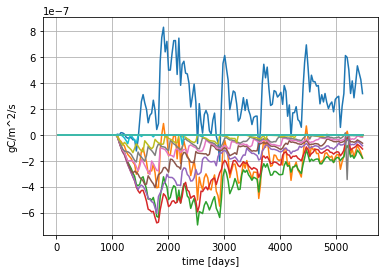

In [41]:
# Monthly (timestep)
for z in range(leaflayers): 
    plt.plot(time[:],nu_cls2[:,z])
plt.grid()
plt.xlabel("time [days]")
plt.ylabel("gC/m^2/s")

Text(0, 0.5, 'gC/m^2/s')

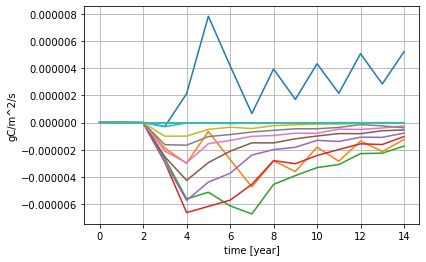

In [42]:
# Yearly
for z in range(leaflayers): 
    plt.plot(np.arange(years),nu_cls2_yearly[:,z])
plt.grid()
plt.xlabel("time [year]")
plt.ylabel("gC/m^2/s")

Canopy level 2 (understory) seems to have pretty consistent negative net uptake for each layer.  Ryan noted that this is due to there being "more respiration than photosynthesis" in that layer, which makes sense giving this is understory (I assume).

## Plot out the yearly net uptake by canopy leaf level

Text(0.5, 0, 'gC/m^2/year')

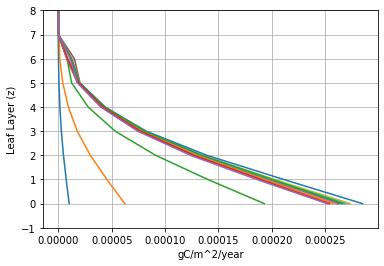

In [43]:
# Canopy level 1
fig,ax = plt.subplots()
for i in range(0,int(years),1):
    ax.plot(nu_cls1_yearly[i,:],np.arange(leaflayers))
# plt.plot(nu_cls1_yearly[0,:],np.arange(leaflayers))
# plt.plot(nu_cls1_yearly[15,:],np.arange(leaflayers))
ax.grid()
plt.ylim([-1,8])
plt.ylabel("Leaf Layer (z)")
plt.xlabel("gC/m^2/year")
# plt.xlim([-0.00002,0.0003])

We can see that the yearly net uptake decreases as we go deeper into the canopy layers

(-1, 11)

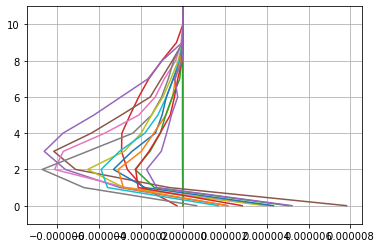

In [44]:
# Canopy level 2
fig,ax = plt.subplots()
for i in range(int(years)):
    ax.plot(nu_cls2_yearly[i,:],np.arange(0,leaflayers)) # scaled by 1e6
ax.grid()
plt.ylim([-1,11])
# plt.ylim([-1,2])
# plt.xlim([-0.1,1.35])

Not unexpected to see the yearly net uptake is wholly negative for each layer (with the one year) based on the uptake vs time above

## Plot out the leaf cost

Text(0, 0.5, 'gC/m^2/s')

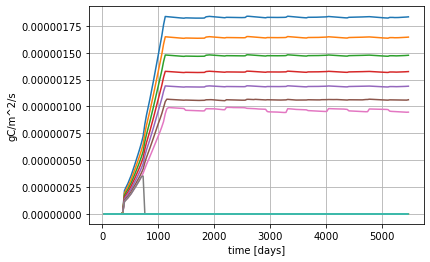

In [45]:
# Canopy
for i in range(0,30):
    plt.plot(time[:],lc_cls1[:,i])
plt.grid()
plt.xlabel("time [days]")
plt.ylabel("gC/m^2/s")
# plt.ylim([0.015,0.025])

Text(0, 0.5, 'gC/m^2/s')

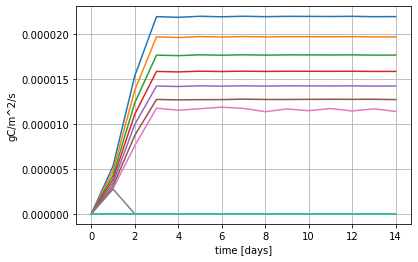

In [46]:
# Yearly 
for z in range(leaflayers): 
    plt.plot(np.arange(years),lc_cls1_yearly[:,z])
plt.grid()
plt.xlabel("time [days]")
plt.ylabel("gC/m^2/s")

Text(0, 0.5, 'gC/m^2/s')

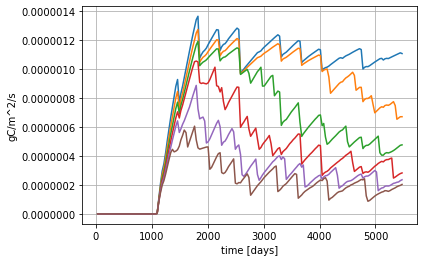

In [47]:
# Understory
for i in range(0,6):
    plt.plot(time[:],lc_cls2[:,i])
plt.grid()
plt.xlabel("time [days]")
plt.ylabel("gC/m^2/s")
# plt.ylim([0.018,0.02])

Text(0, 0.5, 'gC/m^2/s')

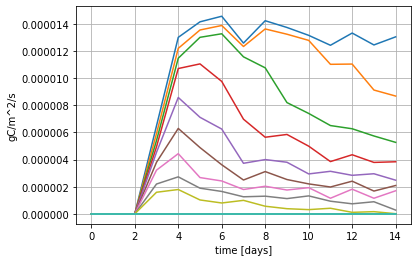

In [48]:
# Yearly 
for z in range(leaflayers): 
    plt.plot(np.arange(years),lc_cls2_yearly[:,z])
plt.grid()
plt.xlabel("time [days]")
plt.ylabel("gC/m^2/s")

## Calculate and plot yearly 'net net' uptake by timestep

In [49]:
nnu_cls1 = lc_cls1[:]-nu_cls1[:]
nnu_cls2 = lc_cls2[:]-nu_cls2[:]
nnu_cls1_vsplit = np.vsplit(nnu_cls1[:],years)
nnu_cls2_vsplit = np.vsplit(nnu_cls2[:],years)
nnu_cls1_yearly_fromts = np.sum(nnu_cls1_vsplit,1)
nnu_cls2_yearly_fromts = np.sum(nnu_cls2_vsplit,1)
nnu_cls1_yearly = lc_cls1_yearly - nu_cls1_yearly
nnu_cls2_yearly = lc_cls2_yearly - nu_cls2_yearly

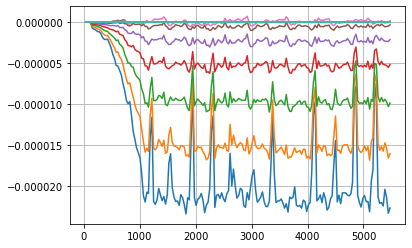

In [50]:
# Canopy
for i in range(0,30):
    plt.plot(time[:],nnu_cls1[:,i])
plt.grid()
# plt.ylim([0.018,0.02])

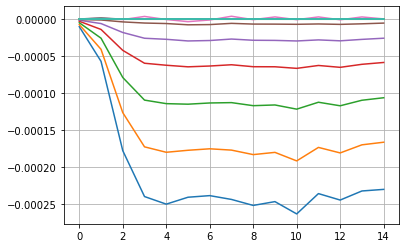

In [51]:
# Canopy
for i in range(0,30):
    plt.plot(np.arange(int(years)),nnu_cls1_yearly[:,i])
plt.grid()
# plt.ylim([0.018,0.02])

Text(0.5, 0, 'gC/m^2/year')

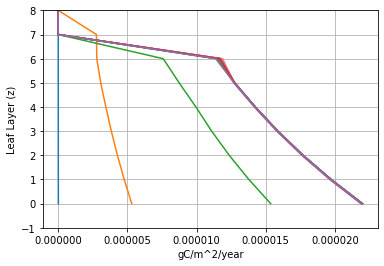

In [52]:
# Canopy level 1
fig,ax = plt.subplots()
for i in range(0,int(years),1):
    ax.plot(lc_cls1_yearly[i,:],np.arange(leaflayers))
ax.grid()
plt.ylim([-1,8])
plt.ylabel("Leaf Layer (z)")
plt.xlabel("gC/m^2/year")
# plt.xlim([-0.00002,0.0003])

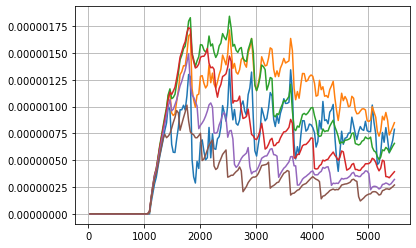

In [53]:
# Understory
for i in range(0,6):
    plt.plot(time[:],nnu_cls2[:,i])
plt.grid()
# plt.ylim([0.018,0.02])

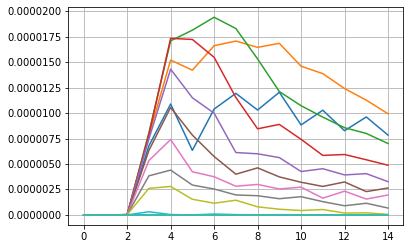

In [54]:
# Canopy
for i in range(0,30):
    plt.plot(np.arange(int(years)),nnu_cls2_yearly[:,i])
plt.grid()
# plt.ylim([0.018,0.02])

## Investigate the lai responses per leaf layer

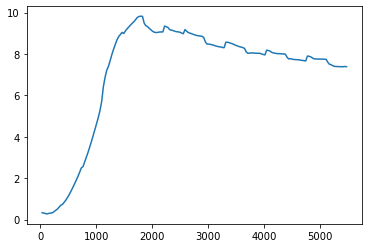

In [55]:
plt.plot(time[:],tlai[:])

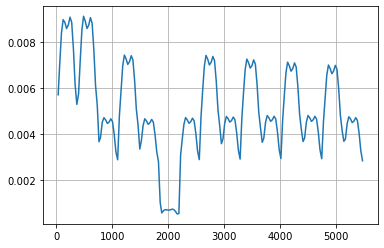

In [56]:
plt.plot(time[:],laisun[:,6])
plt.grid()

In [57]:
np.sum(laisha[:])

1851.1938

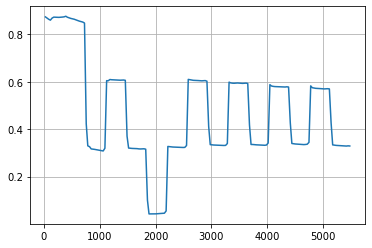

In [58]:
plt.plot(time[:],laisha[:,6])
plt.grid()

(-0.005, 0.02)

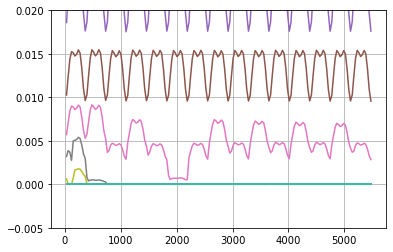

In [59]:
for i in range(0,leaflayers):
    plt.plot(time[:],lsun_cls1[:,i])
plt.grid()
plt.ylim([-0.005,0.02])

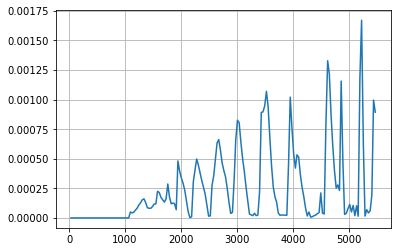

In [60]:
plt.plot(time[:],lsun_cls2[:,8])
# for i in range(0,leaflayers):
#     plt.plot(time[:],lsun_cls2[:,i])
plt.grid()
# plt.ylim([-0.005,0.02])

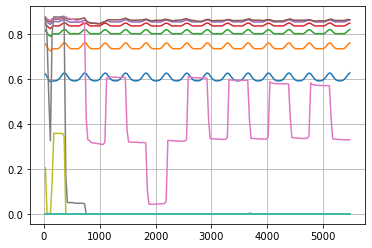

In [61]:
for i in range(0,leaflayers):
    plt.plot(time[:],lsha_cls1[:,i])
plt.grid()
# plt.ylim([-0.005,0.02])

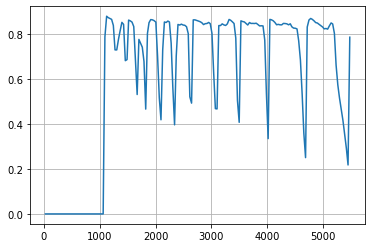

In [62]:
plt.plot(time[:],lsha_cls2[:,6])
# for i in range(0,leaflayers):
#     plt.plot(time[:],lsha_cls2[:,i])
plt.grid()
# plt.ylim([-0.005,0.02])

In [63]:
tlsha_cls1 = np.sum(lsha_cls1)
tlsha_cls2 = np.sum(lsha_cls2)
tlsun_cls1 = np.sum(lsun_cls1)
tlsun_cls2 = np.sum(lsun_cls2)

In [64]:
tlsha_cls1+tlsun_cls1

1048.385

In [65]:
tlsha_cls2+tlsun_cls2

908.5875

In [66]:
np.shape(lsun_cls1)

(180, 30, 1)